In [1]:
import numpy as np
import os
import nltk

import torch
import torch.nn
import torchtext.vocab as vocab
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")


In [2]:
def load_data():
    df = pd.read_csv("./data/markets.csv", encoding='utf_8_sig')
    # print(df.columns)
    #df.drop(df[df.cat== 'Seafood'].index, inplace= True )
    texts = df['name'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['cat'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [6]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [7]:
def load_embeddings():
    
    cache = '.vector_cache'
    if not os.path.exists(cache):
        os.mkdir(cache)

    word2vec = vocab.Vectors(name=r'./word2vec/word2vec_300dim.txt', cache=cache)

    return word2vec

In [8]:
def encode_text_to_features(vector, text):
    vectors = vector.get_vecs_by_tokens(text.split())
    sentence_vector = torch.mean(vectors, dim=0)
    return sentence_vector.tolist()

In [9]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

In [10]:
data = pd.read_csv('./data/markets.csv', encoding='utf_8_sig')
data.head()

,Unnamed: 0,name,cat
0,0,little ones baby wipes unscented,Baby care
1,1,essentials baby wipes fragrance free,Baby care
2,2,huggies baby wipes unscented,Baby care
3,3,huggies essentials walker nappies unisex 13-18...,Baby care
4,4,silk baby wipes fragrance free,Baby care


In [11]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,name,cat
0,little ones baby wipes unscented,Baby care
1,essentials baby wipes fragrance free,Baby care
2,huggies baby wipes unscented,Baby care
3,huggies essentials walker nappies unisex 13-18...,Baby care
4,silk baby wipes fragrance free,Baby care


In [12]:
data = data.apply([text_preprocess])

In [13]:
data.columns = ['name', 'cat']

In [14]:
data

,name,cat
0,little ones baby wipes unscented,baby care
1,essentials baby wipes fragrance free,baby care
2,huggies baby wipes unscented,baby care
3,huggies essentials walker nappies unisex 13-18...,baby care
4,silk baby wipes fragrance free,baby care
...,...,...
13487,daim chocolate bar,chocolate sweets snacks
13488,romanos supreme pizza minis 450g,deli chilled foods
13489,san remo gluten free pasta fettuccine,health wellness
13490,watties wok creations stir fry sauce malaysian...,meal ingredients


In [15]:
newfile = open('corpus.txt', 'w', encoding='utf_8_sig')
for i in range(len(data['name'])):
    newline = data['name'][i] + ' ' + data['cat'][i] + '\n'
    newfile.write(newline)

In [16]:
#https://mp.weixin.qq.com/s/UFiZsPfXwg8lQUsGXcgHjA

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing

In [17]:
readlines = open('corpus.txt', 'r', encoding='utf_8_sig')

model = Word2Vec(LineSentence(readlines),
                 size=300, window=5, min_count=10, sample=1e-5,
                 workers=multiprocessing.cpu_count(), iter=5,)

model.wv.save_word2vec_format(r'./word2vec/word2vec_300dim.txt', binary=False)

In [18]:
texts, labels, id2label = load_data()
texts = [text_preprocess(t) for t in texts]
vector = load_embeddings()
features = [encode_text_to_features(vector, text) for text in texts]
print("data len:", len(texts))
print("id2label",id2label)

data len: 13492
id2label {0: 'Deli  chilled foods', 1: 'Breakfast foods', 2: 'Office  entertainment', 3: 'Meat', 4: 'Frozen foods', 5: 'Meal ingredients', 6: 'Health  wellness', 7: 'Bakery', 8: 'Chocolate, sweets  snacks', 9: 'Drinks - hot  cold', 10: 'Home  kitchenware', 11: 'Fruit  vegetables', 12: 'Toys  party needs', 13: 'Liquor - beer  cider', 14: 'Biscuits  crackers', 15: 'Baking  cooking', 16: 'Canned  prepared foods', 17: 'Liquor - wine', 18: 'Cleaning  homecare', 19: 'Personal care', 20: 'Pharmacy', 21: 'Clothing  manchester', 22: 'Seafood', 23: 'Baby care', 24: 'Pet care'}


In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=3)

In [22]:
# knn
k = len(id2label)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "knn")

knn: acc:0.7328787429587904, recall:0.6766254009122578, f1 score:0.7058177770539886
                           precision    recall  f1-score   support

                 Pet care       0.97      0.95      0.96       151
                 Pharmacy       0.00      0.00      0.00         1
         Health  wellness       0.60      0.52      0.56       151
       Cleaning  homecare       0.71      0.83      0.76       184
            Liquor - wine       0.45      0.95      0.61       241
                Baby care       0.95      0.78      0.86       125
         Meal ingredients       0.86      0.74      0.80       214
                   Bakery       0.89      0.70      0.79       118
       Biscuits  crackers       0.91      0.71      0.80       108
     Liquor - beer  cider       0.94      0.86      0.90        59
Chocolate, sweets  snacks       0.74      0.87      0.80       183
                  Seafood       0.47      0.31      0.37        26
        Toys  party needs       0.78      0.

In [23]:
# # logistic
model = LinearRegression()
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
# print(predict_labels)
predict_labels = [np.round(p) for p in predict_labels]
max_label = len(id2label) - 1
predict_labels = [l if max_label >= l else max_label for l in predict_labels]
min_label = 0
predict_labels = [l if min_label <= l else min_label for l in predict_labels]
evaluation(predict_labels, y_test,id2label, "logistic")

logistic: acc:0.07560035576638008, recall:0.07877055344164148, f1 score:0.06941961115193275
                           precision    recall  f1-score   support

                 Pet care       0.42      0.13      0.19       151
                 Pharmacy       0.00      0.00      0.00         1
         Health  wellness       0.03      0.01      0.01       151
       Cleaning  homecare       0.09      0.03      0.04       184
            Liquor - wine       0.33      0.07      0.12       241
                Baby care       0.08      0.06      0.07       125
         Meal ingredients       0.16      0.10      0.12       214
                   Bakery       0.08      0.10      0.09       118
       Biscuits  crackers       0.07      0.09      0.08       108
     Liquor - beer  cider       0.03      0.10      0.05        59
Chocolate, sweets  snacks       0.06      0.07      0.06       183
                  Seafood       0.01      0.12      0.02        26
        Toys  party needs       0.03

In [24]:
import lightgbm as lgb

def lgb_model(x_train, x_test, y_train, y_test, verbose):
    params = {'num_leaves': 60,
    'min_data_in_leaf': 30,
    'objective': 'multiclass',
    'num_class': 33,
    'max_depth': -1,
    'learning_rate': 0.03,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 15,
    'metric': 'multi_error',
    "random_state": 2020
          }

    model = lgb.train(params
                      , lgb.Dataset(x_train, y_train)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(x_test, y_test)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                     )

    print('Predicting...')
    y_prob = model.predict(x_test, num_iteration=model.best_iteration)
    y_pred = [list(x).index(max(x)) for x in y_prob]
    print("AUC score: {:<8.5f}".format(metrics.accuracy_score(y_pred, y_test)))
    report = metrics.classification_report(y_test, y_pred, target_names=[id2label[i] for i in range(len(id2label))])
    print(report)
    
    return True

In [ ]:
final = lgb_model(x_train, x_test, y_train, y_test, verbose=False)

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
model = OneVsRestClassifier(SVC()) 
model.fit(x_train, y_train) 
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "svm")

svm: acc:0.8920841980432849, recall:0.8389959213418702, f1 score:0.8394722611556472
                           precision    recall  f1-score   support

            Personal care       0.91      0.96      0.94       213
       Drinks - hot  cold       0.92      0.97      0.94       183
         Meal ingredients       0.86      0.86      0.86       214
                   Bakery       0.94      0.86      0.90       118
                Baby care       0.94      0.96      0.95       125
             Frozen foods       0.91      0.93      0.92       210
                 Pet care       0.98      0.99      0.98       151
       Cleaning  homecare       0.94      0.90      0.92       184
     Clothing  manchester       0.99      0.91      0.95        78
Chocolate, sweets  snacks       0.84      0.92      0.88       183
     Liquor - beer  cider       0.94      1.00      0.97        59
    Office  entertainment       0.61      0.77      0.68        52
        Toys  party needs       0.84      0.

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

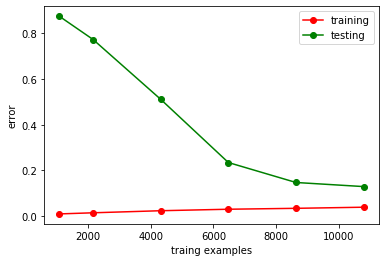

In [23]:
train_sizes,train_score,test_score = learning_curve(SVC(),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

In [ ]:
# from sklearn.naive_bayes import MultinomialNB